# Emulating Images with VAE


In [ ]:
import numpy as np
import tensorflow as tf

def generate_grf(size=32, beta=2.5, seed=None):
    """Generate a 2D Gaussian Field with a power law power spectrum.
    Generate white noise in Fourier space and multiply by the square root of the power spectrum.
    Then take the inverse Fourier transform to get the field."""

    if seed is not None:
        np.random.seed(seed)
    
    kx = np.fft.fftfreq(size).reshape(-1, 1)
    ky = np.fft.fftfreq(size).reshape(1, -1)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1 # avoid division by zero

    # power spectrum
    power_spectrum = k**(-beta)

    # generate random fourier coefficients with gaussian noise
    real_part = np.random.normal(scale=np.sqrt(power_spectrum)/np.sqrt(2))
    imag_part = np.random.normal(scale=np.sqrt(power_spectrum)/np.sqrt(2))
    fourier_field = real_part + 1j*imag_part

    # inverse fourier transform
    field = np.fft.ifft2(fourier_field).real
    field -= np.mean(field)
    field /= np.std(field)

    return field

Text(0.5, 1.0, 'Gaussian Random Field')

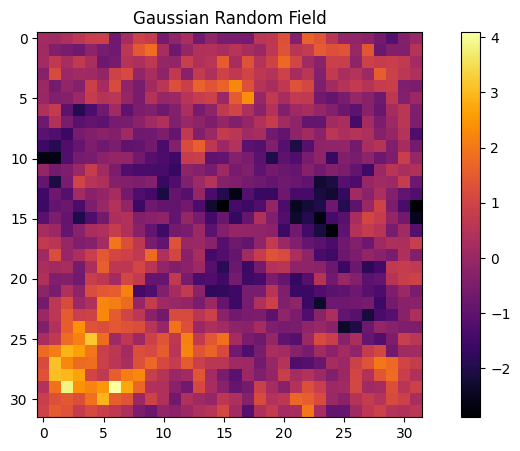

In [2]:
import matplotlib.pyplot as plt

theta_example = 2
grf_image = generate_grf(beta=theta_example)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cb = ax.imshow(grf_image, cmap='inferno')
plt.colorbar(cb, ax=ax)
ax.set_title('Gaussian Random Field')

In [3]:
def generate_data(n_samples=1000, size=32, beta_range=(4, 6), seed=None):
    """Generate a dataset of 2D Gaussian Fields with power law power spectrum."""
    
    if seed is not None:
        np.random.seed(seed)
    
    thetas = np.random.uniform(*beta_range, n_samples)
    data = np.array([generate_grf(size=size, beta=theta) for theta in thetas])
    return data[..., np.newaxis].astype(np.float32), thetas[..., np.newaxis].astype(np.float32) # channel dim for tensorflow like RGB but with one channel

(10000, 32, 32, 1) (10000, 1)


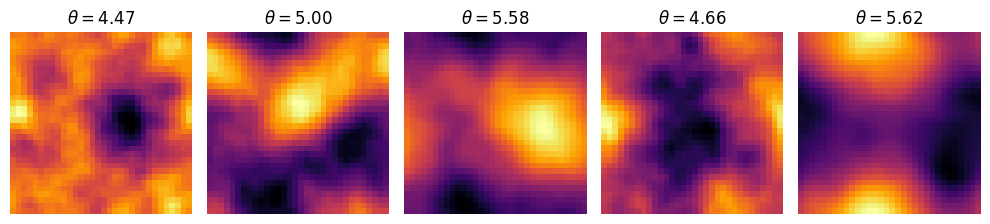

In [4]:
signals, thetas = generate_data(n_samples=10000, size=32, beta_range=(4, 6))
print(signals.shape, thetas.shape)

fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    ax[i].imshow(signals[i, ..., 0], cmap='inferno')
    ax[i].set_title(f'$\\theta = {thetas[i, 0]:.2f}$')
    ax[i].axis('off')
plt.tight_layout()

normsignals = (signals  - np.min(signals)) / (np.max(signals) - np.min(signals))
normthetas = (thetas - np.min(thetas)) / (np.max(thetas) - np.min(thetas))


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 10
theta_dim = 1

encoder_inputs = keras.Input(shape=(32,32, 1))
# number of filters, kernel size, activation function, strides, padding
# strides is the step size of the kernel
# padding is the way to handle the edges of the image
x = layers.Conv2D(8, 2, activation="leaky_relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(8, 2, activation="leaky_relu", strides=2, padding="same")(x)
x = layers.Conv2D(16, 2, activation="leaky_relu", strides=1, padding="same")(x)
x = layers.Conv2D(16, 2, activation="leaky_relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

theta_inputs = keras.Input(shape=(theta_dim,))
theta_dense = layers.Dense(16, activation="tanh")(theta_inputs)

concat = layers.Concatenate()([x, theta_dense])
hidden = layers.Dense(128, activation="tanh")(concat)

z_mean = layers.Dense(latent_dim, name="z_mean")(hidden)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(hidden)

def sampling(args):
    # reparameterization trick
    # ensures that the model remains differentiable
    # we would introduce stochasticity if we directly sampled from the latent space
    # meaning the gradients would not be able to flow back through the network
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    # z = z_mean + sqrt(var) * epsilon
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# used to wrap a custom function as a layer
z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = keras.Model([encoder_inputs, theta_inputs], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 8)            40        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 8)            264       ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 16)           528       ['conv2d_1[0][0]']            
                                                                                            

In [6]:
# decoder input
z_input = keras.Input(shape=(latent_dim,))
theta_input_dec = keras.Input(shape=(theta_dim,))

# combine latent space with theta
concat_dec = layers.Concatenate()([z_input, theta_input_dec])
hidden_dec = layers.Dense(64, activation="relu")(concat_dec)
hidden_dec = layers.Dense(4*4*16, activation="relu")(hidden_dec)
hidden_dec = layers.Reshape((4, 4, 16))(hidden_dec)

# deconvolution layers to upsample back to 64*64
# number of filters, kernel size, activation function, strides, padding
# strides is the upsampling factor essentially strides=2 doubles the width and height
# effectively learned upsampling
# Replace with Conv2DTranspose
x = layers.Conv2DTranspose(16, kernel_size=2, strides=2, activation="tanh", padding="same")(hidden_dec)
x = layers.Conv2DTranspose(16, kernel_size=2, strides=1, activation="tanh", padding="same")(x)
x = layers.Conv2DTranspose(8, kernel_size=2, strides=1, activation="tanh", padding="same")(x)
x = layers.Conv2DTranspose(8, kernel_size=2, strides=2, activation="tanh", padding="same")(x)
x = layers.Conv2DTranspose(8, kernel_size=2, strides=1, activation="tanh", padding="same")(x)
x = layers.Conv2DTranspose(8, kernel_size=2, strides=2, activation="tanh", padding="same")(x)

"""x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(hidden_dec)
x = layers.Conv2D(16, 3, activation="leaky_relu", padding="same")(x)

x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(hidden_dec)
x = layers.Conv2D(16, 3, activation="leaky_relu", padding="same")(x)

x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
x = layers.Conv2D(16, 3, activation="leaky_relu", padding="same")(x)

x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
x = layers.Conv2D(16, 3, activation="leaky_relu", padding="same")(x)"""
# back to one image and one channel using (3,3) kernel and sigmoid
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)

decoder = keras.Model([z_input, theta_input_dec], decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 11)                   0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 64)                   768       ['concatenate_1[0][0]'] 

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs):
        image = inputs[0]
        theta = inputs[1]
        z_mean, z_log_var, z = self.encoder([image, theta])
        reconstructed = self.decoder([z, theta])
        return reconstructed

vae = VAE(encoder, decoder)

def vae_loss(x, reconstructed_x, z_mean, z_log_var, beta_kl=1):
    # makes sure the images out of the decoder are similar to the input
    reconstruction_loss = keras.losses.mean_squared_error(x, reconstructed_x)
    # standard kl between two gaussians. Basicallyregularises the latent space so
    # it looks like a standard normal
    reconstruction_loss = tf.reduce_mean(reconstruction_loss)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    #print(reconstruction_loss, kl_loss)
    return reconstruction_loss + beta_kl*kl_loss, reconstruction_loss, kl_loss


Epoch 0, Loss: 0.03399733453989029, Reconstruction Loss: 0.03309020400047302, KL Loss: 0.9071298837661743,
 Validation Loss: 0.00764959491789341, valRL: 0.00653503555804491, valKL: 1.1145594120025635, 
z_mean: -0.09417887032032013, z_var: 0.10340063273906708


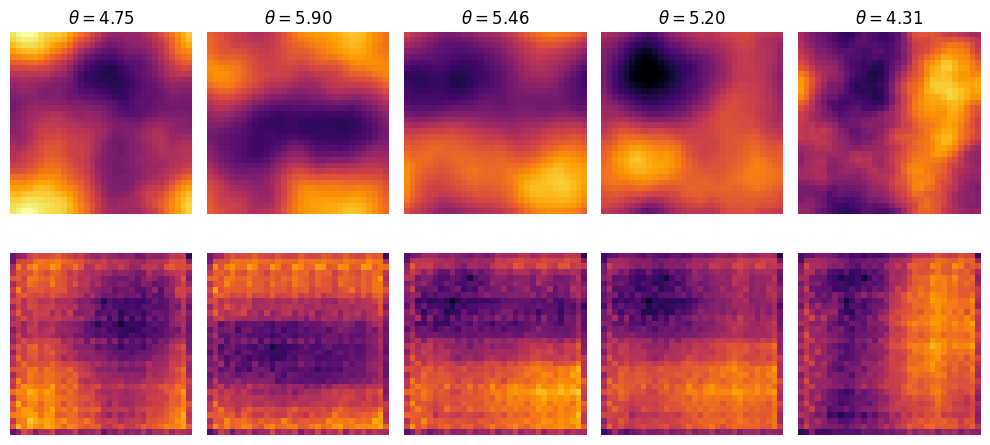

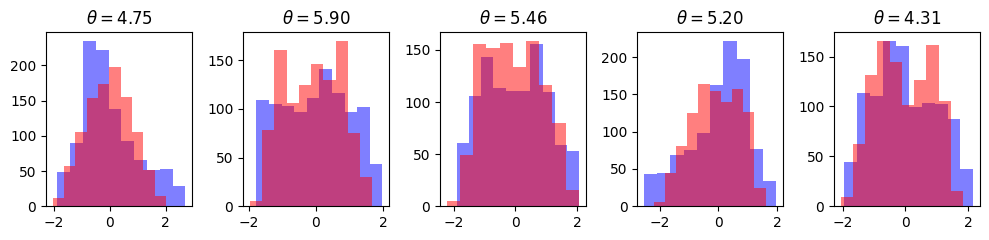

Epoch 1, Loss: 0.005961810238659382, Reconstruction Loss: 0.00467320904135704, KL Loss: 1.288601040840149,
 Validation Loss: 0.00463525066152215, valRL: 0.0032191595528274775, valKL: 1.416090965270996, 
z_mean: -0.004076540935784578, z_var: 0.06716278940439224
Epoch 2, Loss: 0.004348214250057936, Reconstruction Loss: 0.002950704889371991, KL Loss: 1.3975090980529785,
 Validation Loss: 0.004096018150448799, valRL: 0.0027301497757434845, valKL: 1.3658682107925415, 
z_mean: -0.009365043602883816, z_var: 0.0938454270362854
Epoch 3, Loss: 0.004023937974125147, Reconstruction Loss: 0.0026488464791327715, KL Loss: 1.375091552734375,
 Validation Loss: 0.003880539909005165, valRL: 0.0025368782225996256, valKL: 1.3436615467071533, 
z_mean: 0.007821348495781422, z_var: 0.12126021087169647
Epoch 4, Loss: 0.0038829040713608265, Reconstruction Loss: 0.002515398897230625, KL Loss: 1.3675053119659424,
 Validation Loss: 0.00379580887965858, valRL: 0.002461297670379281, valKL: 1.334511160850525, 
z_mean

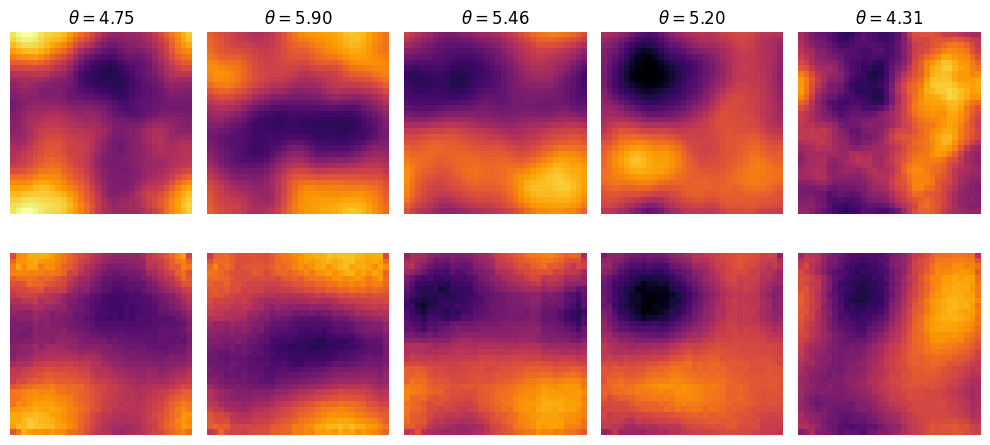

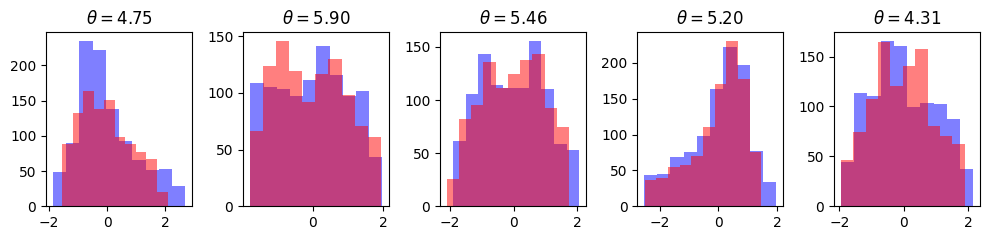

Epoch 6, Loss: 0.003695562481880188, Reconstruction Loss: 0.0023776863235980272, KL Loss: 1.3178763389587402,
 Validation Loss: 0.003649813588708639, valRL: 0.0022470219992101192, valKL: 1.4027913808822632, 
z_mean: 0.03868326172232628, z_var: 0.1831711381673813
Epoch 7, Loss: 0.0036454573273658752, Reconstruction Loss: 0.0023368732072412968, KL Loss: 1.3085839748382568,
 Validation Loss: 0.0036234590224921703, valRL: 0.0023550710175186396, valKL: 1.268388032913208, 
z_mean: 0.024041561409831047, z_var: 0.19366513192653656
Epoch 8, Loss: 0.003613716922700405, Reconstruction Loss: 0.0023104429710656404, KL Loss: 1.3032742738723755,
 Validation Loss: 0.003581698052585125, valRL: 0.0022944905795156956, valKL: 1.2872074842453003, 
z_mean: 0.01613525114953518, z_var: 0.20535270869731903
Epoch 9, Loss: 0.00359181291423738, Reconstruction Loss: 0.0022884185891598463, KL Loss: 1.3033941984176636,
 Validation Loss: 0.0035724840126931667, valRL: 0.0023171037901192904, valKL: 1.2553800344467163, 

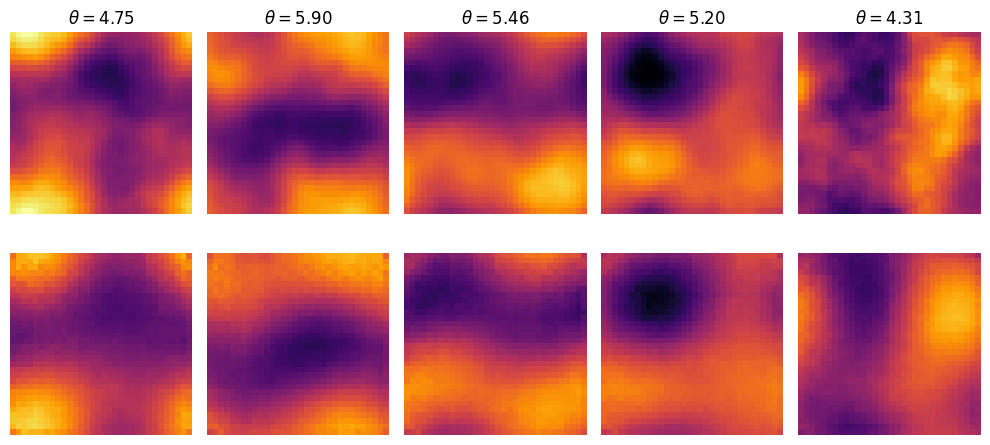

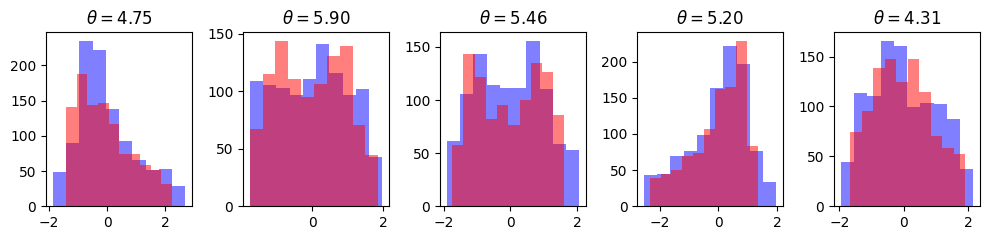

Epoch 11, Loss: 0.003562928643077612, Reconstruction Loss: 0.002260439097881317, KL Loss: 1.3024896383285522,
 Validation Loss: 0.003519239369779825, valRL: 0.0021987888030707836, valKL: 1.3204505443572998, 
z_mean: 0.04441119730472565, z_var: 0.20813144743442535
Epoch 12, Loss: 0.0035357887391000986, Reconstruction Loss: 0.0022294106893241405, KL Loss: 1.3063777685165405,
 Validation Loss: 0.003501079510897398, valRL: 0.002147766062989831, valKL: 1.3533134460449219, 
z_mean: 0.03456391766667366, z_var: 0.18725034594535828
Epoch 13, Loss: 0.003521367209032178, Reconstruction Loss: 0.002204978372901678, KL Loss: 1.3163889646530151,
 Validation Loss: 0.0034912279807031155, valRL: 0.002133605070412159, valKL: 1.3576228618621826, 
z_mean: 0.0319565124809742, z_var: 0.17315152287483215
Epoch 14, Loss: 0.003513708943501115, Reconstruction Loss: 0.0021930828224867582, KL Loss: 1.3206264972686768,
 Validation Loss: 0.00353605835698545, valRL: 0.0022812495008111, valKL: 1.254808783531189, 
z_me

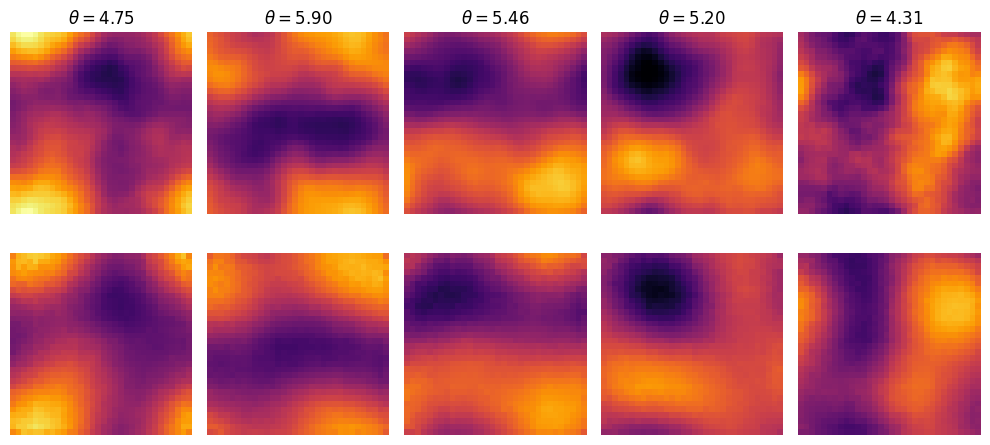

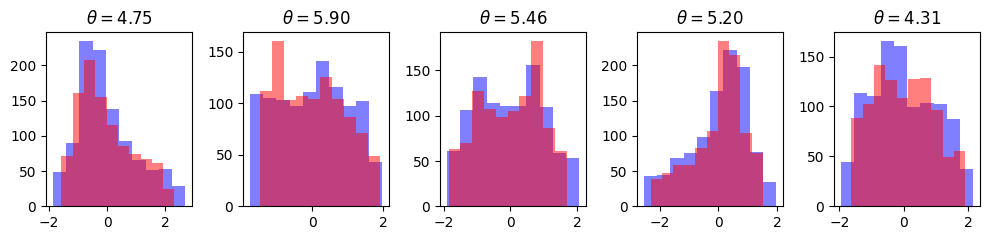

Epoch 16, Loss: 0.0034907441586256027, Reconstruction Loss: 0.002166508696973324, KL Loss: 1.3242355585098267,
 Validation Loss: 0.0034816223196685314, valRL: 0.002222055336460471, valKL: 1.2595667839050293, 
z_mean: 0.050982046872377396, z_var: 0.18108204007148743
Epoch 17, Loss: 0.0034822255838662386, Reconstruction Loss: 0.0021612157579511404, KL Loss: 1.321009874343872,
 Validation Loss: 0.003478572703897953, valRL: 0.002199330599978566, valKL: 1.2792420387268066, 
z_mean: 0.03588036075234413, z_var: 0.18666653335094452
Epoch 18, Loss: 0.003475491190329194, Reconstruction Loss: 0.002150745363906026, KL Loss: 1.3247461318969727,
 Validation Loss: 0.0034508765675127506, valRL: 0.0021898294799029827, valKL: 1.2610468864440918, 
z_mean: 0.03872447460889816, z_var: 0.18194693326950073
Epoch 19, Loss: 0.0034816123079508543, Reconstruction Loss: 0.002155362395569682, KL Loss: 1.3262497186660767,
 Validation Loss: 0.0034728574100881815, valRL: 0.0021381417755037546, valKL: 1.33471560478210

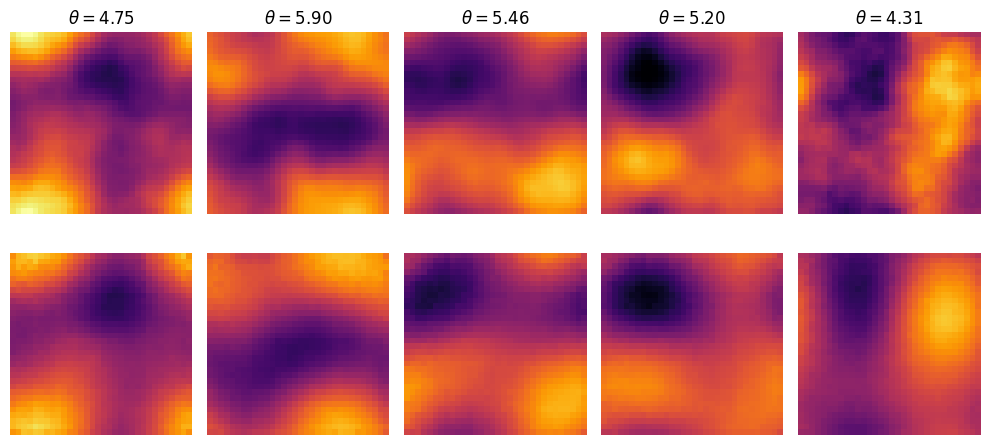

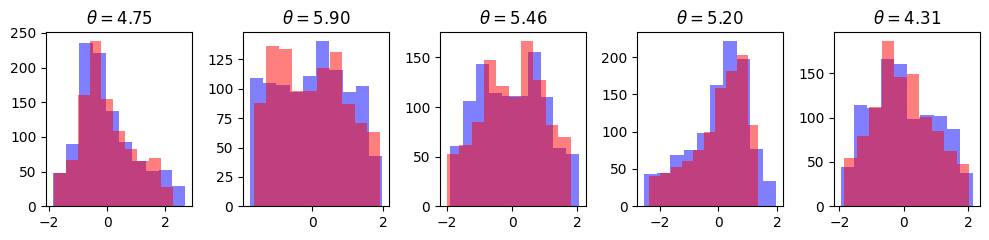

Epoch 21, Loss: 0.0034713640343397856, Reconstruction Loss: 0.002145554404705763, KL Loss: 1.3258095979690552,
 Validation Loss: 0.0034994054585695267, valRL: 0.0021220059134066105, valKL: 1.3773993253707886, 
z_mean: 0.0397287979722023, z_var: 0.17229710519313812
Epoch 22, Loss: 0.003465127432718873, Reconstruction Loss: 0.002140395576134324, KL Loss: 1.324731707572937,
 Validation Loss: 0.0034432774409651756, valRL: 0.0022133570164442062, valKL: 1.2299202680587769, 
z_mean: 0.039531540125608444, z_var: 0.18519577383995056
Epoch 23, Loss: 0.0034622561652213335, Reconstruction Loss: 0.002140967408195138, KL Loss: 1.3212887048721313,
 Validation Loss: 0.0034512600395828485, valRL: 0.0021756310015916824, valKL: 1.275628924369812, 
z_mean: 0.03699213266372681, z_var: 0.1823226660490036
Epoch 24, Loss: 0.003460130887106061, Reconstruction Loss: 0.002138818148523569, KL Loss: 1.321312427520752,
 Validation Loss: 0.0034571662545204163, valRL: 0.0021140347234904766, valKL: 1.3431313037872314,

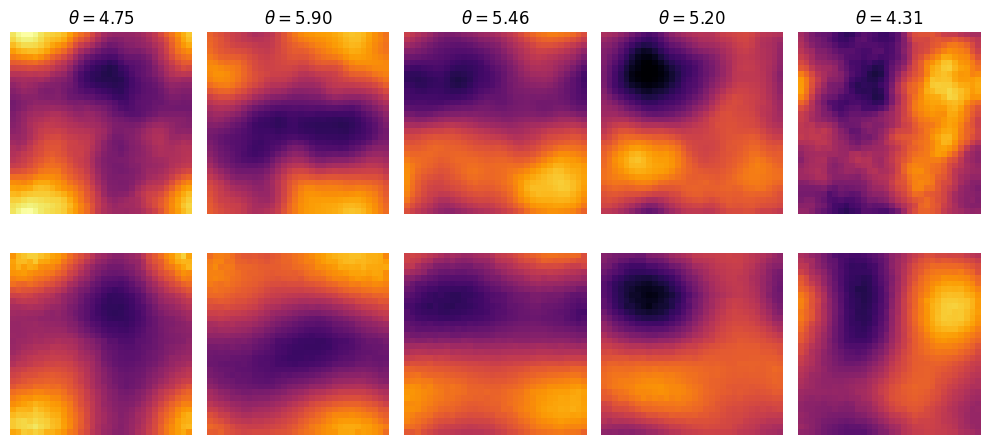

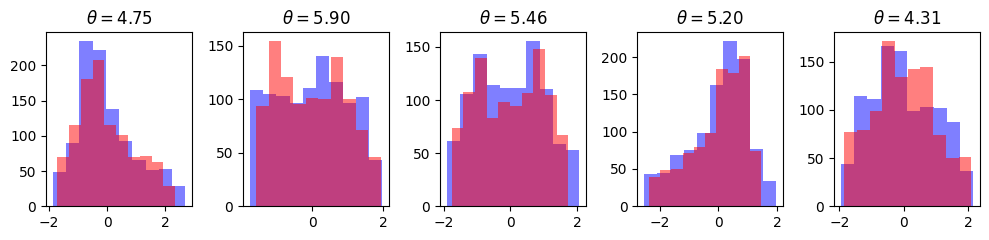

Epoch 26, Loss: 0.003455095924437046, Reconstruction Loss: 0.002132342429831624, KL Loss: 1.3227535486221313,
 Validation Loss: 0.0034361316356807947, valRL: 0.0021180971525609493, valKL: 1.3180344104766846, 
z_mean: 0.048788923770189285, z_var: 0.18033279478549957
Epoch 27, Loss: 0.003447513096034527, Reconstruction Loss: 0.0021288422867655754, KL Loss: 1.3186707496643066,
 Validation Loss: 0.0034347001928836107, valRL: 0.002097374526783824, valKL: 1.3373255729675293, 
z_mean: 0.046217888593673706, z_var: 0.1768762469291687
Epoch 28, Loss: 0.0034446141216903925, Reconstruction Loss: 0.0021270730067044497, KL Loss: 1.3175408840179443,
 Validation Loss: 0.003436705330386758, valRL: 0.002102782716974616, valKL: 1.3339225053787231, 
z_mean: 0.04775701090693474, z_var: 0.17838342487812042
Epoch 29, Loss: 0.003443315625190735, Reconstruction Loss: 0.002124423161149025, KL Loss: 1.3188923597335815,
 Validation Loss: 0.0034506400115787983, valRL: 0.002127392217516899, valKL: 1.323247671127319

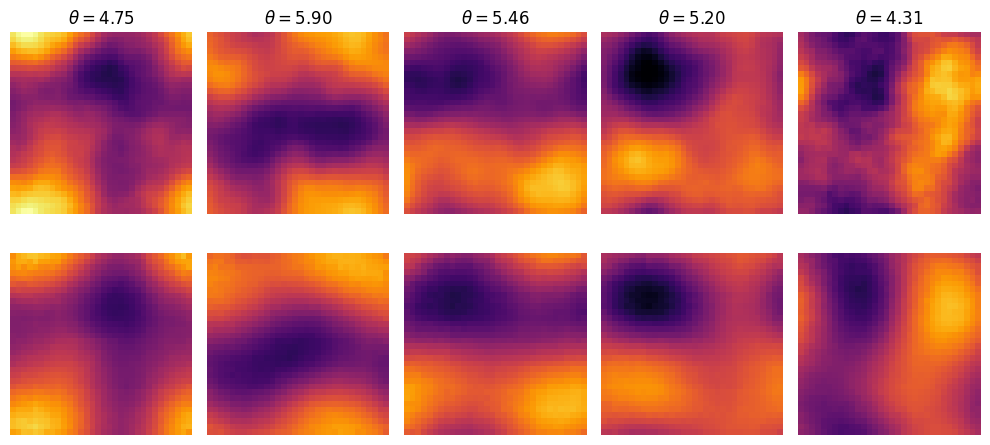

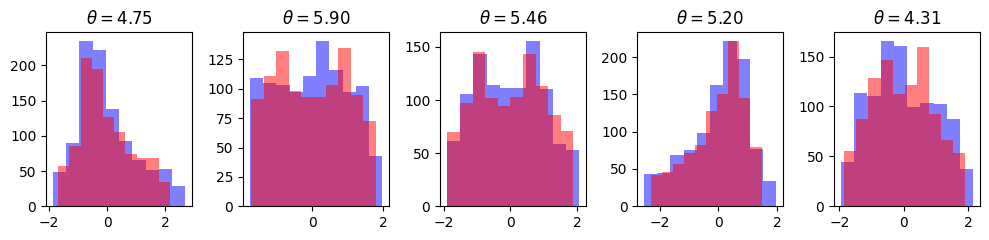

Epoch 31, Loss: 0.0034439670853316784, Reconstruction Loss: 0.0021196925081312656, KL Loss: 1.3242745399475098,
 Validation Loss: 0.0034327320754528046, valRL: 0.002126669744029641, valKL: 1.30606210231781, 
z_mean: 0.053785283118486404, z_var: 0.18059130012989044
Epoch 32, Loss: 0.0034464967902749777, Reconstruction Loss: 0.0021223051007837057, KL Loss: 1.3241915702819824,
 Validation Loss: 0.00343510415405035, valRL: 0.002151831518858671, valKL: 1.2832727432250977, 
z_mean: 0.041387639939785004, z_var: 0.18057437241077423
Epoch 33, Loss: 0.003443207126110792, Reconstruction Loss: 0.0021181637421250343, KL Loss: 1.3250436782836914,
 Validation Loss: 0.003421328729018569, valRL: 0.00212665181607008, valKL: 1.2946768999099731, 
z_mean: 0.04549960792064667, z_var: 0.17586669325828552
Epoch 34, Loss: 0.0034367209300398827, Reconstruction Loss: 0.0021113900002092123, KL Loss: 1.3253306150436401,
 Validation Loss: 0.003440333064645529, valRL: 0.002151122549548745, valKL: 1.289210557937622, 

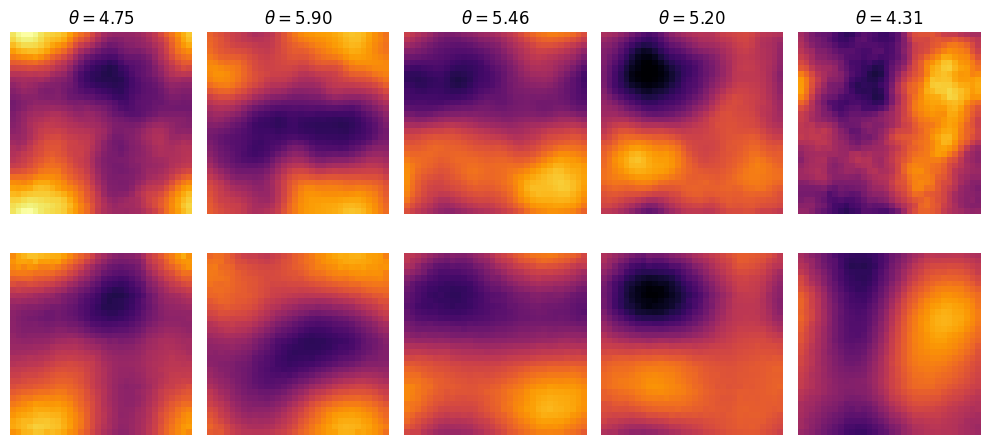

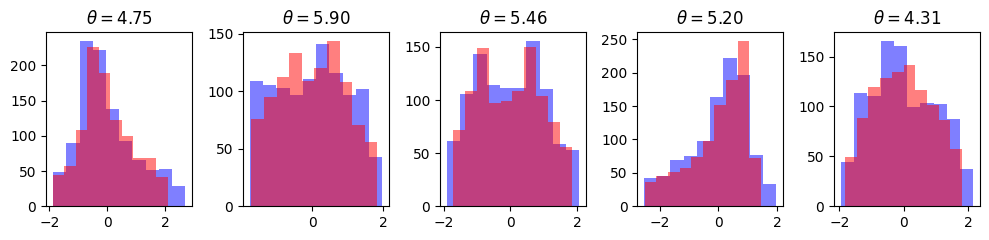

Epoch 36, Loss: 0.003435667371377349, Reconstruction Loss: 0.0021147942170500755, KL Loss: 1.3208727836608887,
 Validation Loss: 0.0034550719428807497, valRL: 0.002160049043595791, valKL: 1.2950228452682495, 
z_mean: 0.0369444265961647, z_var: 0.18454810976982117
Epoch 37, Loss: 0.0034310496412217617, Reconstruction Loss: 0.002112149726599455, KL Loss: 1.3188996315002441,
 Validation Loss: 0.0034316726960241795, valRL: 0.0021629200782626867, valKL: 1.2687526941299438, 
z_mean: 0.036189742386341095, z_var: 0.1861889362335205
Epoch 38, Loss: 0.0034347588662058115, Reconstruction Loss: 0.002111351117491722, KL Loss: 1.3234072923660278,
 Validation Loss: 0.0034838011488318443, valRL: 0.0022420035675168037, valKL: 1.2417974472045898, 
z_mean: 0.05012062191963196, z_var: 0.18528561294078827
Epoch 39, Loss: 0.003432793077081442, Reconstruction Loss: 0.002109132008627057, KL Loss: 1.3236610889434814,
 Validation Loss: 0.0034426329657435417, valRL: 0.0021683932282030582, valKL: 1.27423954010009

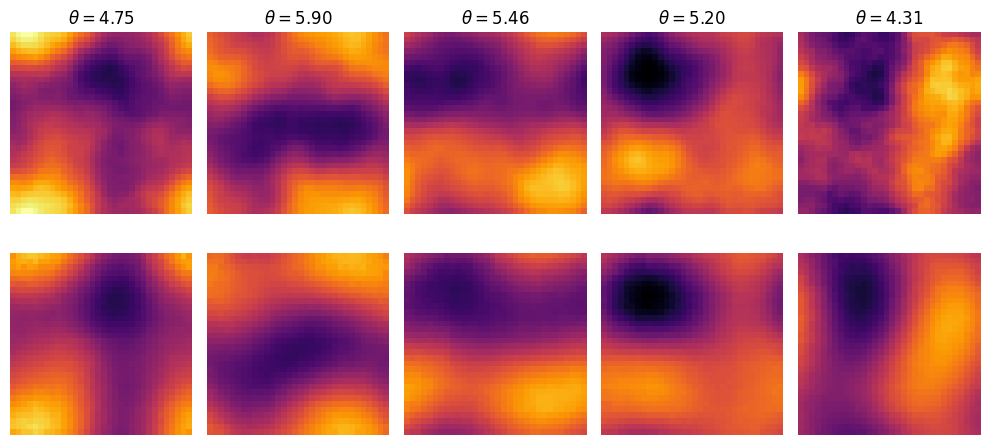

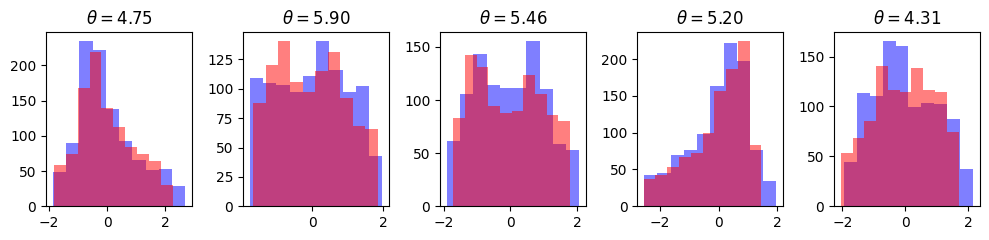

Epoch 41, Loss: 0.0034249434247612953, Reconstruction Loss: 0.0021035289391875267, KL Loss: 1.3214144706726074,
 Validation Loss: 0.0034550228156149387, valRL: 0.0021613065619021654, valKL: 1.2937160730361938, 
z_mean: 0.048513978719711304, z_var: 0.17854954302310944
Epoch 42, Loss: 0.003427129937335849, Reconstruction Loss: 0.0021058591082692146, KL Loss: 1.3212709426879883,
 Validation Loss: 0.003449298208579421, valRL: 0.0021004858426749706, valKL: 1.3488123416900635, 
z_mean: 0.03861790895462036, z_var: 0.1755029708147049
Epoch 43, Loss: 0.0034248533193022013, Reconstruction Loss: 0.002105012768879533, KL Loss: 1.3198405504226685,
 Validation Loss: 0.003427298739552498, valRL: 0.0020870279986411333, valKL: 1.340270757675171, 
z_mean: 0.04423431307077408, z_var: 0.17863726615905762
Epoch 44, Loss: 0.0034196386113762856, Reconstruction Loss: 0.002102245343849063, KL Loss: 1.317393183708191,
 Validation Loss: 0.0034696394577622414, valRL: 0.0021984304767102003, valKL: 1.27120876312255

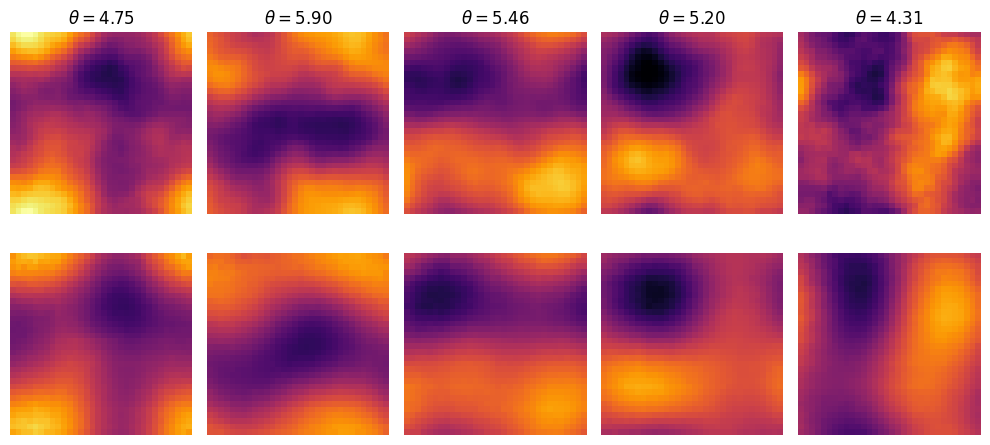

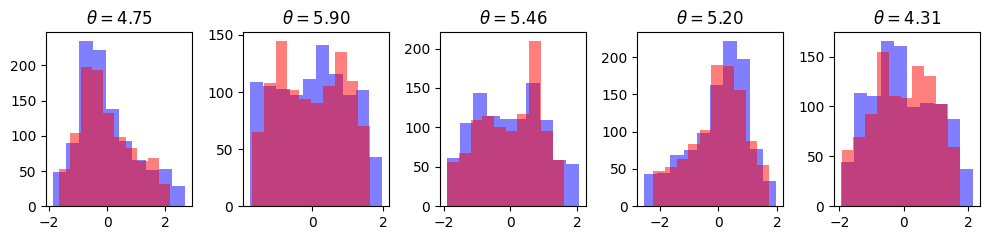

Epoch 46, Loss: 0.003423068905249238, Reconstruction Loss: 0.002099854638800025, KL Loss: 1.323214054107666,
 Validation Loss: 0.003437466686591506, valRL: 0.002135439543053508, valKL: 1.3020271062850952, 
z_mean: 0.028098246082663536, z_var: 0.17461836338043213
Early stopping at epoch 46


In [8]:

valsignals, valthetas = generate_data(n_samples=1000, size=32, beta_range=(4, 6))
normvalsignals = (valsignals  - np.min(signals)) / (np.max(signals) - np.min(signals))
normvalthetas = (valthetas - np.min(thetas)) / (np.max(thetas) - np.min(thetas))

optimizer = keras.optimizers.Adam(lr=1e-3)

dataset = tf.data.Dataset.from_tensor_slices((normsignals, normthetas))

# Explicitly batch your data
batch_size = 50  # You can adjust this depending on your available memory
dataset = dataset.batch(batch_size)

# Optionally, shuffle the dataset to ensure randomness
#dataset = dataset.shuffle(buffer_size=1000)

epochs = 200
best_val_loss = np.inf
count, patience = 0, 10
# Train the VAE model
for e in range(epochs):
    losses, rls, kls = [], [], []
    for images_batch, thetas_batch in dataset:
        # images_batch should have shape (batch_size, 64, 64, 1)
        # thetas_batch should have shape (batch_size, 1)

        with tf.GradientTape() as tape:
            reconstructed = vae([images_batch, thetas_batch])
            # loss for each image and pixel
            z_mean, z_var_log = vae.encoder([images_batch, thetas_batch])[0:2]
            loss, rl, kl = vae_loss(images_batch, reconstructed, 
                                    *vae.encoder([images_batch, thetas_batch])[0:2],
                                    beta_kl=0.001)
        grad = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grad, vae.trainable_weights))
        losses.append(loss.numpy())
        rls.append(rl.numpy())
        kls.append(kl.numpy())

    valloss, rl, kl = vae_loss(normvalsignals, vae([normvalsignals, normvalthetas]),
                               *vae.encoder([normvalsignals, normvalthetas])[0:2],
                               beta_kl=0.001)
    valloss = tf.reduce_mean(valloss)
    print(f"Epoch {e}, Loss: {np.mean(losses)}, Reconstruction Loss: {np.mean(rls)}, KL Loss: {np.mean(kls)},\n" +
            f" Validation Loss: {valloss}, valRL: {np.mean(rl)}, valKL: {np.mean(kl)}, \n" +
          f"z_mean: {np.mean(z_mean.numpy())}, z_var: {np.mean(tf.exp(z_var_log).numpy())}")
    
    if valloss < best_val_loss:
        vae.save_weights('best_vae.h5')
        best_val_loss = valloss
        count = 0
    else:
        count += 1
        if count > patience:
            print(f"Early stopping at epoch {e}")
            break

    if e%5 == 0:
        test_data, test_thetas = generate_data(n_samples=5, size=32, beta_range=(4, 6), seed=42)

        normtest_thetas = (test_thetas - np.min(thetas)) / (np.max(thetas) - np.min(thetas))
        normtest_data = (test_data - np.min(signals)) / (np.max(signals) - np.min(signals))
        reconstructed = vae([normtest_data, normtest_thetas])
        reconstructed = reconstructed.numpy()
        #signal_dec = vae.decoder([np.random.normal(size=(5, latent_dim)), normtest_thetas])
        #reconstructed = signal_dec.numpy()
        reconstructed = reconstructed * (np.max(signals) - np.min(signals)) + np.min(signals)

        fig, ax = plt.subplots(2, 5, figsize=(10, 5))
        for i in range(5):
            ax[0, i].imshow(test_data[i, ..., 0], cmap='inferno',
                    vmin=test_data.flatten().min(), vmax=test_data.flatten().max())
            ax[0, i].set_title(f'$\\theta = {test_thetas[i, 0]:.2f}$')
            ax[0, i].axis('off')
            ax[1, i].imshow(reconstructed[i, ..., 0], cmap='inferno',
                    vmin=test_data.flatten().min(), vmax=test_data.flatten().max())
            ax[1, i].axis('off')
        plt.tight_layout()
        plt.show()  

        fig, ax = plt.subplots(1, 5, figsize=(10, 2.5))
        for i in range(5):
            ax[i].hist(test_data[i, ..., 0].flatten(), alpha=0.5, color='b')
            ax[i].set_title(f'$\\theta = {test_thetas[i, 0]:.2f}$')
            ax[i].hist(reconstructed[i, ..., 0].flatten(), alpha=0.5, color='r')
        plt.tight_layout()
        plt.show()

vae.load_weights('best_vae.h5')
            

In [9]:
import numpy as np
from numpy.fft import fft2, fftshift, fftfreq

def compute_power_spectrum_2d(field):
    """
    Computes the spherically averaged power spectrum of a 2D Gaussian random field.
    
    Parameters:
    - field (numpy.ndarray): 2D array representing the Gaussian random field.

    Returns:
    - k_vals (numpy.ndarray): Wavenumber bins.
    - P_k (numpy.ndarray): Spherically averaged power spectrum.
    """
    N = field.shape[0]  # Assuming square field (NxN)
    
    # Compute the 2D Fourier transform and power spectrum
    delta_k = fft2(field)
    power_spectrum = np.abs(delta_k) ** 2  # 2D power spectrum
    
    # Compute wavenumber grid
    kx = fftfreq(N) * N
    ky = fftfreq(N) * N
    kX, kY = np.meshgrid(kx, ky, indexing="ij")
    k_mag = np.sqrt(kX**2 + kY**2)  # Radial wavenumber

    # Define k bins
    k_bins = np.arange(0.5, N//2, 1)  # Bin edges
    k_vals = 0.5 * (k_bins[:-1] + k_bins[1:])  # Bin centers
    P_k = np.zeros_like(k_vals)  # Spherically averaged power spectrum
    
    # Bin power spectrum into annuli
    for i in range(len(k_vals)):
        k_min, k_max = k_bins[i], k_bins[i+1]
        annulus_mask = (k_mag >= k_min) & (k_mag < k_max)
        P_k[i] = np.mean(power_spectrum[annulus_mask]) if np.any(annulus_mask) else 0

    return k_vals, P_k


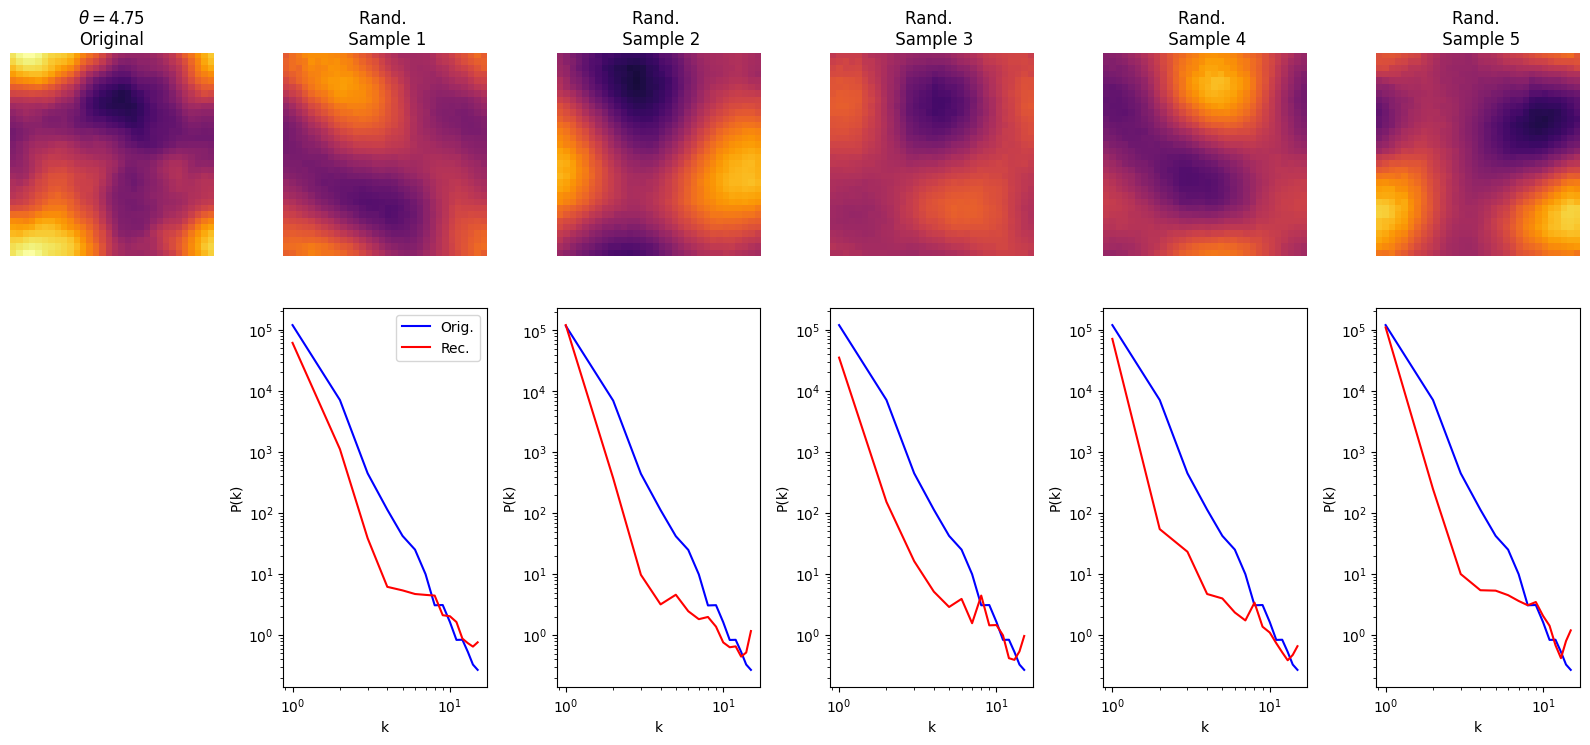

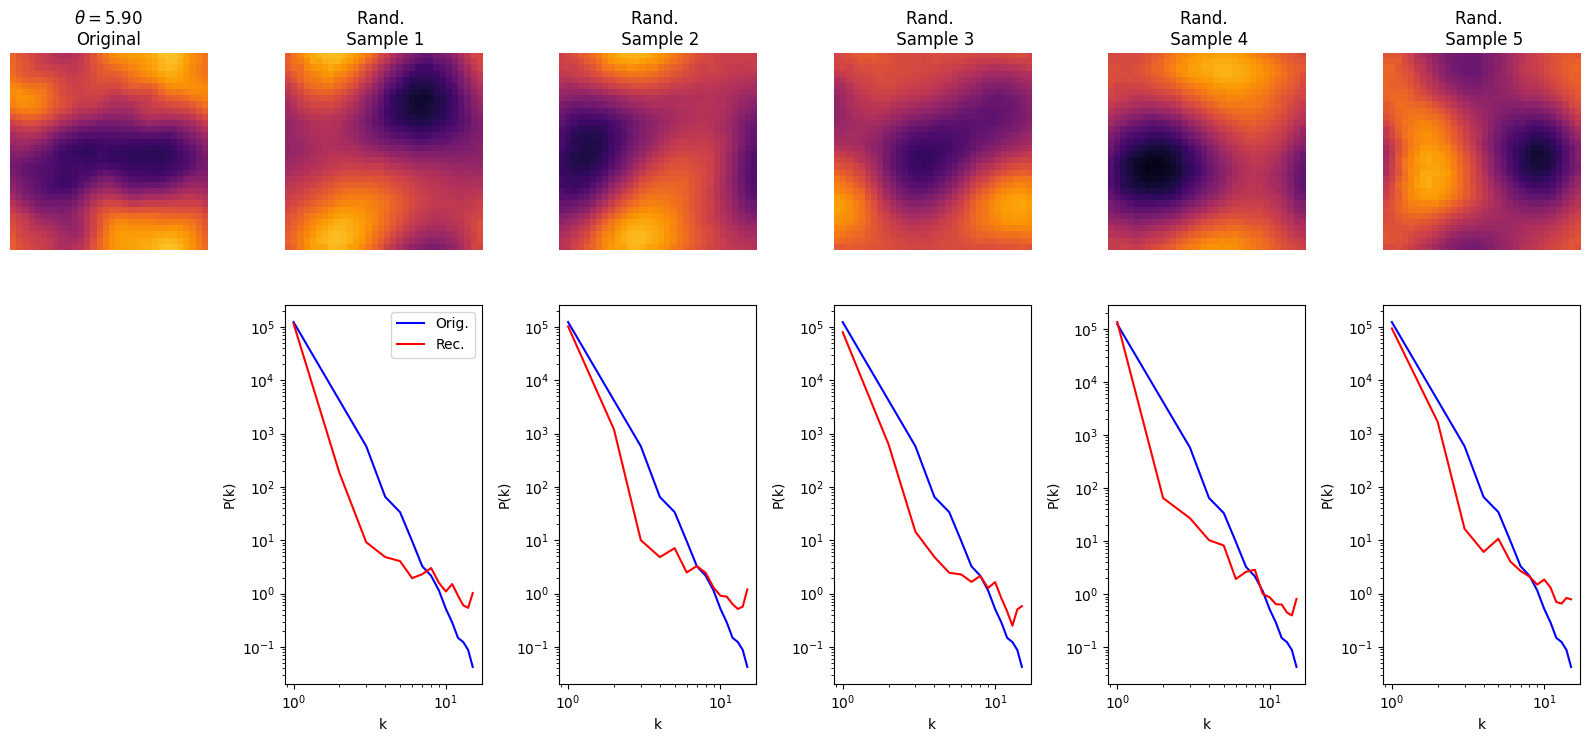

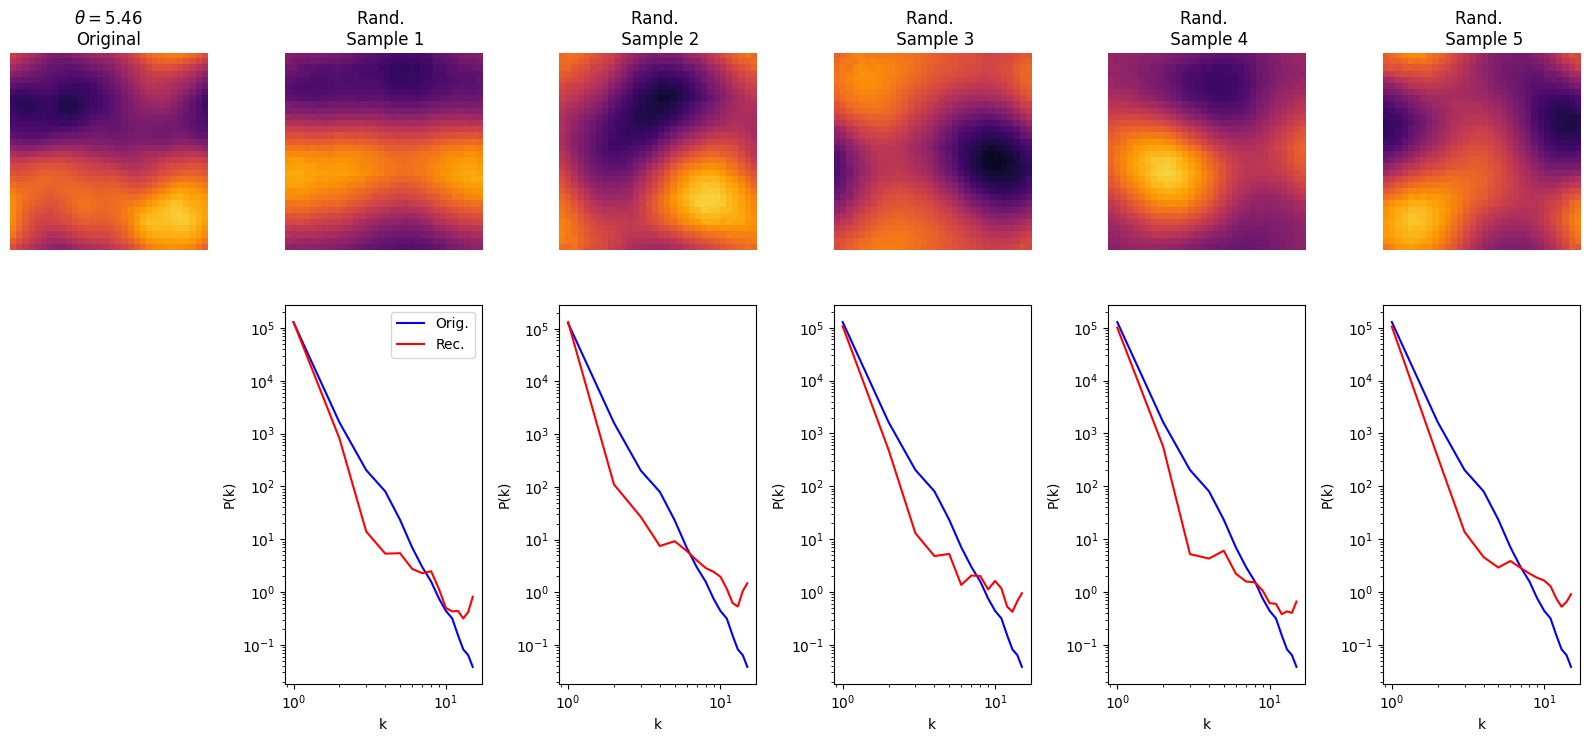

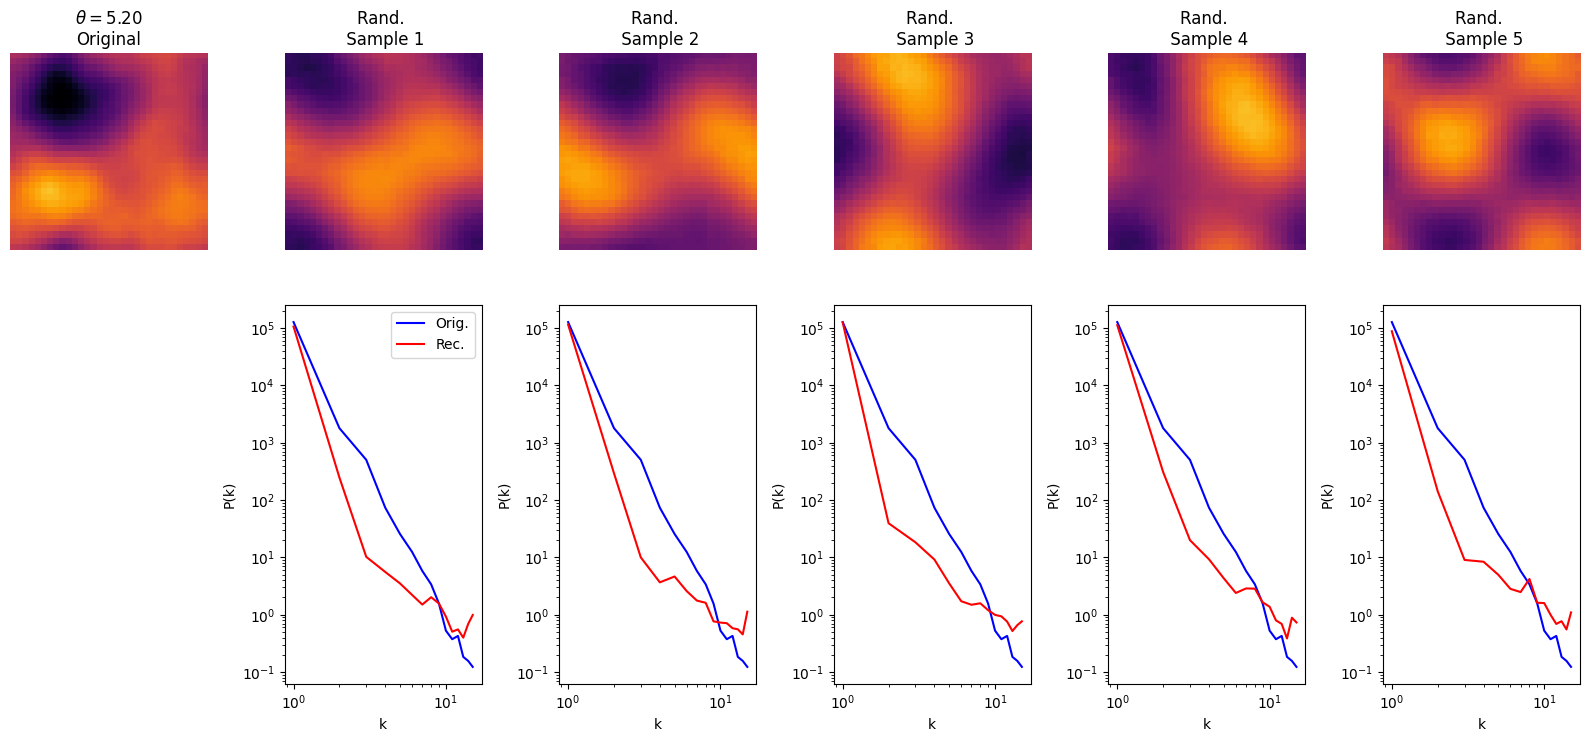

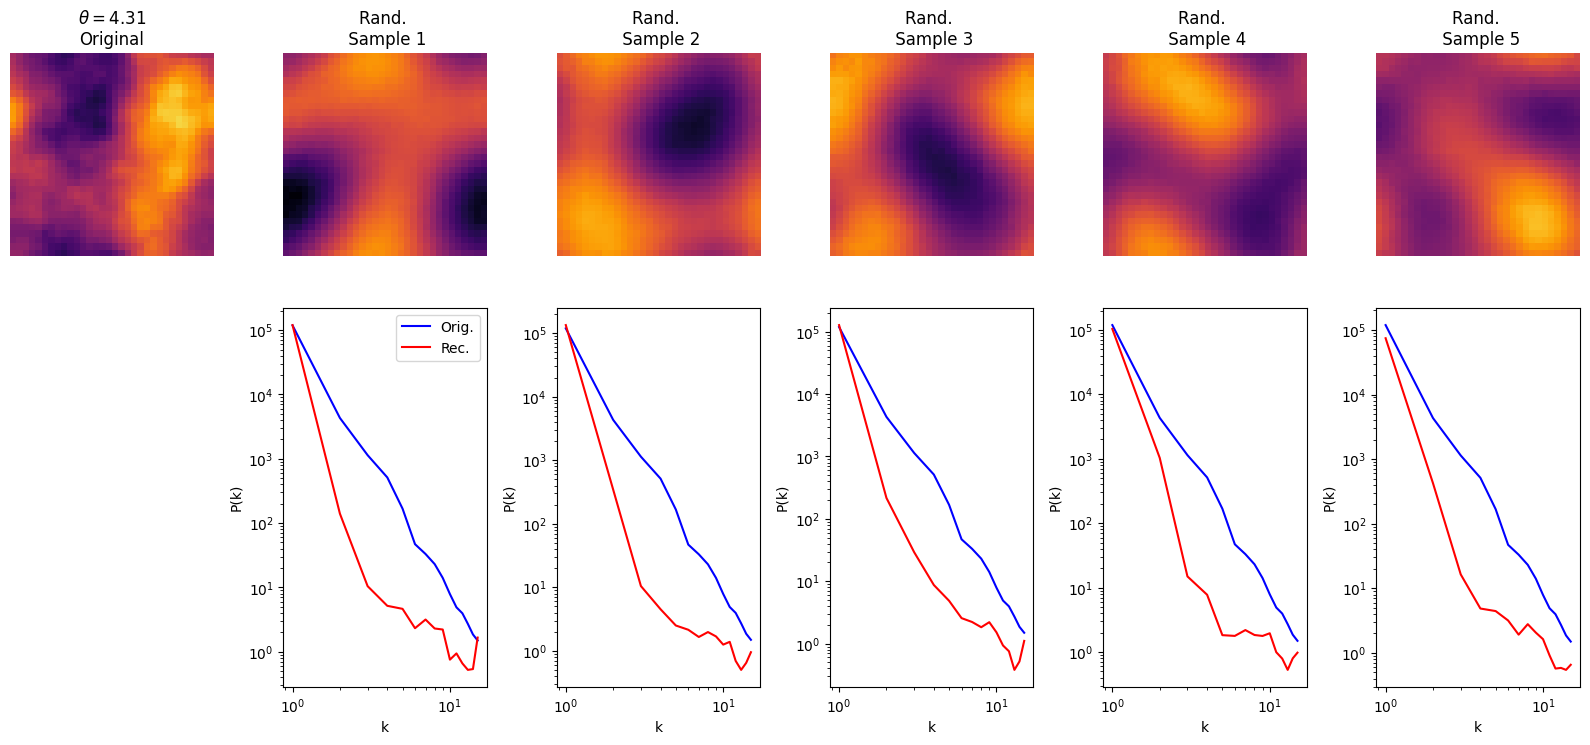

In [18]:

test_data, test_thetas = generate_data(n_samples=5, size=32, beta_range=(4, 6), seed=42)

test_thetas = (test_thetas - np.min(thetas)) / (np.max(thetas) - np.min(thetas))
for i, tt in enumerate(test_thetas):
    tt = np.array([tt]*5)
    signal_dec = vae.decoder([np.random.normal(size=(5, latent_dim)), tt])
    reconstructed = signal_dec.numpy()
    reconstructed = reconstructed * (np.max(signals) - np.min(signals)) + np.min(signals)

    tt = tt * (np.max(thetas) - np.min(thetas)) + np.min(thetas)

    fig, ax = plt.subplots(2, 6, figsize=(16, 8))
    ax[0, 0].imshow(test_data[i, ..., 0], cmap='inferno',
                        vmin=test_data.flatten().min(), vmax=test_data.flatten().max())
    ax[0, 0].set_title(f'$\\theta = {tt[0, 0]:.2f}$\n' + 'Original')
    ax[0, 0].axis('off')
    ax[1, 0].axis('off')
    for j in range(5):
        ax[0, j+1].imshow(reconstructed[j, ..., 0], cmap='inferno',
                        vmin=test_data.flatten().min(), vmax=test_data.flatten().max())
        ax[0, j+1].axis('off')
        ax[0, j+1].set_title(f'Rand. \n Sample {j+1}')
    
        power_spectrum = compute_power_spectrum_2d(test_data[i, ..., 0])

        ax[1, j+1].plot(power_spectrum[0], power_spectrum[1], label='Orig.', color='b')
        power_spectrum = compute_power_spectrum_2d(reconstructed[j, ..., 0])
        ax[1, j+1].plot(power_spectrum[0], power_spectrum[1], label='Rec.', color='r')
        ax[1, j+1].set_xscale('log')
        ax[1,j+1].set_yscale('log')
        ax[1, j+1].set_xlabel('k')
        ax[1, j+1].set_ylabel('P(k)')
    ax[1, 1].legend()
    plt.tight_layout()
    plt.show()

    

